In [86]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def relu3(x):
    return tf.where(x <= 0, 0, x**3)

# differential equation 
# y'' = x, y(0) = 0, y(1) = 0

def true_y(t):
    return(1/6)*t*((t**2)-1)

class ODENet_Shallow(tf.keras.Model):
    def __init__(self, layer1params = 100):
        super(ODENet_Shallow, self).__init__()
        layer1_parameters = layer1params
        self.dense1 = tf.keras.layers.Dense(layer1_parameters, activation=relu3)
        self.dense2 = tf.keras.layers.Dense(1)

    def call(self, x):
        x = self.dense1(x)
        return self.dense2(x)
    
class ODENet_Deep(tf.keras.Model):
    def __init__(self, layer1params = 100, layer2params = 100):
        super(ODENet_Deep, self).__init__()
        layer1_parameters = layer1params
        layer2_parameters = layer2params
        self.dense1 = tf.keras.layers.Dense(layer1_parameters, activation=relu3)
        self.dense2 = tf.keras.layers.Dense(layer2_parameters, activation=relu3)
        self.dense3 = tf.keras.layers.Dense(1)
    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return self.dense3(x)
    
model = ODENet_Shallow()

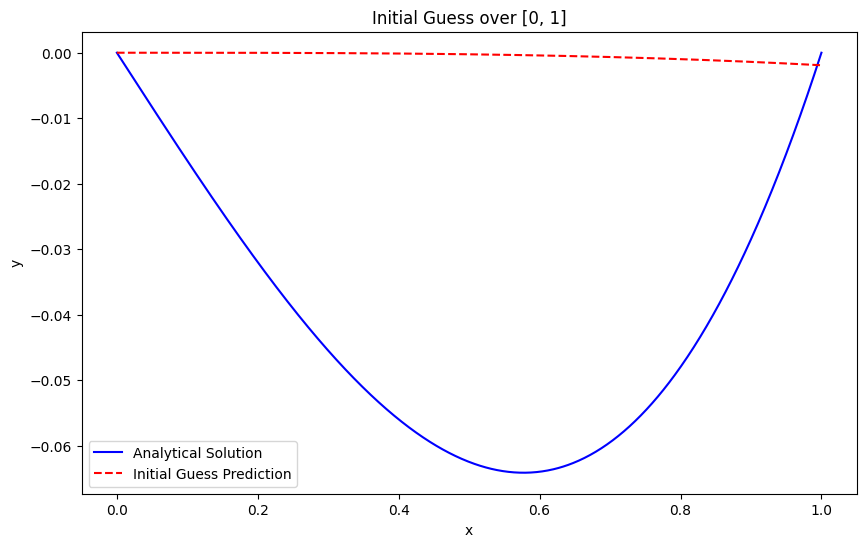

In [87]:
#initial guess

test_n = 1000
x_test = np.linspace(0, 1, test_n).reshape(-1, 1)
y_true = true_y(x_test)
y_pred = model(x_test)

plt.figure(figsize=(10, 6))
plt.plot(x_test, y_true, label='Analytical Solution', color='blue')
plt.plot(x_test, y_pred, label='Initial Guess Prediction', color='red', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Initial Guess over [0, 1]')
plt.show()

In [82]:

# differential equation 
# y'' = x, y(0) = 0, y(1) = 0


def f(x):
    return x

def loss_fn(model, x):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        y = model(x)
        dy_dx = tape.gradient(y, x)
    d2y_dx2 = tape.gradient(dy_dx, x)

    # Residual from the differential equation
    residual = d2y_dx2 - f(x)

    # Calculate the loss as the squared error
    loss = tf.reduce_mean(tf.square(residual))

    # Add boundary conditions to the loss
    loss += 0.5 * tf.square(model(tf.constant([[0.0]], dtype=tf.float32)))
    loss += 0.5 * tf.square(model(tf.constant([[1.0]], dtype=tf.float32)))
    
    return loss

In [88]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

def train_step(model, x):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, x)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss

num_training_points = 1000
x_samples = tf.convert_to_tensor(np.linspace(0, 1, num_training_points).reshape(-1, 1), dtype=tf.float32)


In [ ]:
epochs = 1000
for step in range(epochs):
    loss = train_step(model, x_samples)
    if step % 100 == 0:
        print(f"Step: {step}, Loss: {loss.numpy()}")

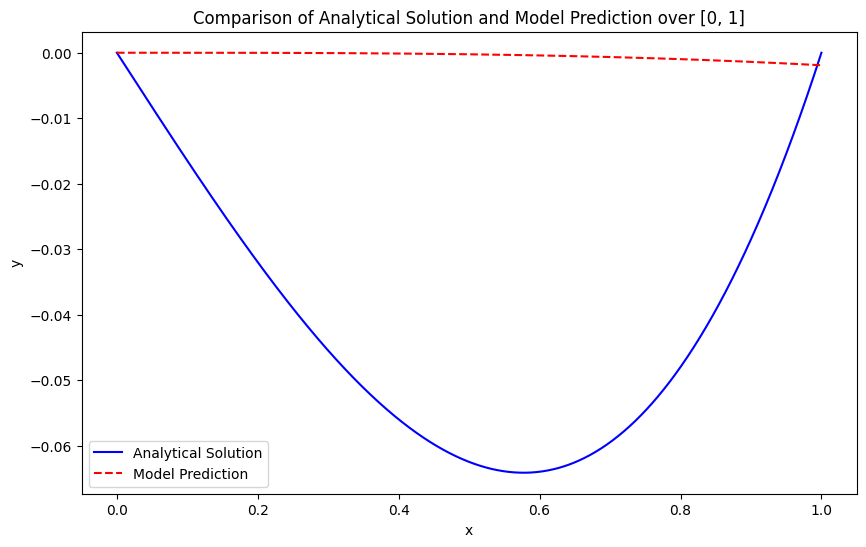

In [89]:
test_n = 1000
x_test = np.linspace(0, 1, test_n).reshape(-1, 1)
y_true = true_y(x_test)
y_pred = model(x_test)

plt.figure(figsize=(10, 6))
plt.plot(x_test, y_true, label='Analytical Solution', color='blue')
plt.plot(x_test, y_pred, label='Model Prediction', color='red', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Comparison of Analytical Solution and Model Prediction over [0, 1]')
plt.show()

In [90]:
max_error_array = np.absolute(y_true - y_pred)
max_error = np.max(max_error_array)
max_error

0.06378473

In [92]:
for i in range(10):
    model = ODENet_Shallow(i*10)

    x_samples = tf.convert_to_tensor(np.linspace(0, 1, 1000).reshape(-1, 1), dtype=tf.float32)
    
    epochs = 1000
    for step in range(epochs):
        loss = train_step(model, x_samples)
    
    test_n = 1000
    x_test = np.linspace(0, 1, test_n).reshape(-1, 1)
    y_true = true_y(x_test)
    y_pred = model(x_test)
    
    max_error_array = np.absolute(y_true - y_pred)
    max_error = np.max(max_error_array)
    print(max_error)

KeyError: 'The optimizer cannot recognize variable ode_net__shallow_7/dense_58/kernel:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.Adam.'